# Using MobileNet for our citrus disease Classifer

### Loading the MobileNet Model

Freeze all layers except the top 4, as we'll only be training the top 4

In [ ]:
from keras.applications.mobilenet import MobileNet

img_rows, img_cols = 224, 224 

MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

for layer in MobileNet.layers:
    layer.trainable = False
        
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17235968/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization F

### function that returns our FC Head

In [ ]:
def addTopModelMobileNet(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### add our FC Head back onto MobileNet

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 5

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## **Linking our Drive to Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Loading citrus fruit disease Dataset

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/Colab Notebooks/fruits/train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/fruits/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 240 images belonging to 5 classes.
Found 60 images belonging to 5 classes.


### Training out Model
- Note we're using checkpointing and early stopping

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Citrus_disease_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 240
nb_validation_samples = 60

epochs = 20
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
7/7 [==============================] - 12s 965ms/step - loss: 1.1858 - accuracy: 0.8895 - val_loss: 0.2868 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.28679, saving model to /content/drive/MyDrive/Colab Notebooks/Citrus_disease_mobileNet.h5
Epoch 2/20
7/7 [==============================] - 4s 502ms/step - loss: 2.1354e-04 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9688

Epoch 00002: val_loss improved from 0.28679 to 0.05619, saving model to /content/drive/MyDrive/Colab Notebooks/Citrus_disease_mobileNet.h5
Epoch 3/20
7/7 [==============================] - 3s 490ms/step - loss: 1.6516e-05 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9688

Epoch 00003: val_loss improved from 0.05619 to 0.03982, saving model to /content/drive/MyDrive/Colab Notebooks/Citrus_disease_mobileNet.h5
Epoch 4/20
7/7 [==============================] - 4s 537ms/step - loss: 4.4955e-05 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9688

Epoch 0000

### Loading our classifer


In [ ]:
from keras.models import load_model

classifier = load_model('/content/drive/MyDrive/Colab Notebooks/Citrus_disease_best_mobileNet.h5')

### Testing our classifer on some test images

Class - blackspot
Prediction


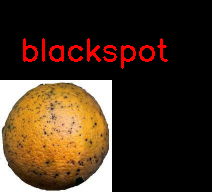

Class - greening
Prediction


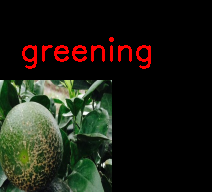

Class - greening
Prediction


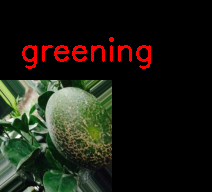

Class - healthy
Prediction


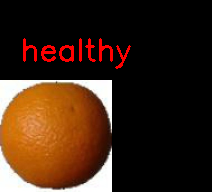

Class - blackspot
Prediction


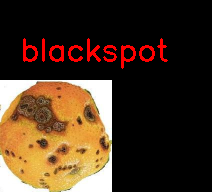

Class - greening
Prediction


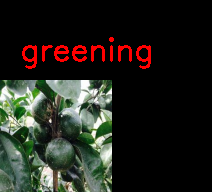

Class - scab
Prediction


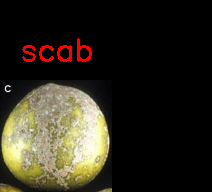

Class - blackspot
Prediction


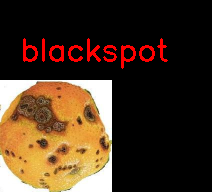

Class - blackspot
Prediction


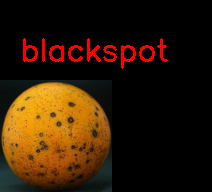

Class - canker
Prediction


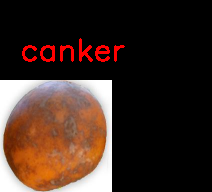

In [ ]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
citrus_disease_dict = {"[0]": "blackspot", 
                      "[1]": "canker",
                      "[2]": "greening",
                      "[3]": "healthy",
                      "[4]": "scab"} 

citrus_disease_dict_n = {"blackspot": "blackspot", 
                      "canker": "canker",
                      "greening": "greening",
                      "healthy": "healthy",
                      "scab": "scab"}

def draw_test(name, pred, im):
    citrus = citrus_disease_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, citrus, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    print(name)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + citrus_disease_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/drive/MyDrive/Colab Notebooks/fruits/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

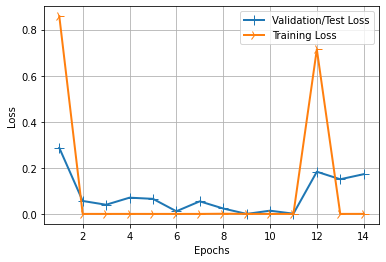

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

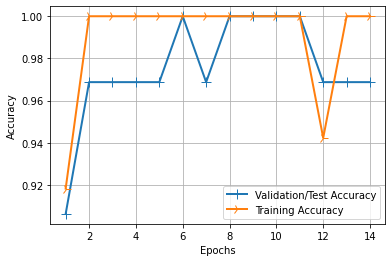

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()